In [1]:
import torch
import torch.nn as nn

In [2]:
GPT_CONFIG_124M = { 
    "vocab_size": 50257, 
    "context_length": 1024, 
    "emb_dim": 768, 
    "n_heads": 12, 
    "n_layers": 12,  # Transformer-Block-Layers
    "drop_rate": 0.1, 
    "qkv_bias": False
}

<!-- ![GPT-Flow](./flow.png) -->
<img src="./flow.png" alt="GPT-Flow" width="600"/>

In [3]:
GPT_CONFIG_124M.keys()

dict_keys(['vocab_size', 'context_length', 'emb_dim', 'n_heads', 'n_layers', 'drop_rate', 'qkv_bias'])

In [4]:
class Dummy_Transformer(nn.Module):
    def __init__(self, config):
        super().__init__()
    
    def forward(self, x):
        return x

In [5]:
class Dummy_NormLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
    
    def forward(self, x):
        return x

In [8]:
GPT_CONFIG_124M.keys()

dict_keys(['vocab_size', 'context_length', 'emb_dim', 'n_heads', 'n_layers', 'drop_rate', 'qkv_bias'])

In [6]:
class Dummy_GPTModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.tok_emb = nn.Embedding(config['vocab_size'], config['emb_dim'])
        self.pos_emb = nn.Embedding(config['context_length'], config['emb_dim'])
        self.drop_emb = nn.Dropout(config['drop_rate'])
        self.transf_layers = nn.Sequential(*[Dummy_Transformer(config) for _ in range(config['n_layers'])])
        self.final_norm = Dummy_NormLayer(config['emb_dim'])
        self.out_head = nn.Linear(config['emb_dim'], config['vocab_size'], bias=False)
    
    def forward(self, x):
        '''x: 2D Matrix'''
        batch_size, seq_len = x.shape 
        tok_emb = self.tok_emb(x) 
        pos_emb = self.pos_emb(torch.arange(seq_len))
        x = tok_emb + pos_emb
        # print(f'x: {x.shape}')
        x = self.drop_emb(x)
        x = self.transf_layers(x)
        x = self.final_norm(x)
        # print(f'x: {x.shape}')
        logits = self.out_head(x)
        # print(f'logits: {logits.shape}')
        return logits

In [10]:
dummy_GPTModel = Dummy_GPTModel(GPT_CONFIG_124M)
x = torch.randint(0, 255, size=(5, 50))
dummy_GPTModel(x).shape # (5, emb_dim, emb_dim)

torch.Size([5, 50, 50257])

In [ ]:
# GPT_CONFIG_124M.keys()
model = Dummy_GPTModel(GPT_CONFIG_124M)
input = torch.arange(16).view(4, 4)
output = model(input)
output.shape # (4, 4, 50257) = (4, 4, vocab_size)

torch.Size([4, 4, 50257])

In [8]:
# Basic Example:
import tiktoken

tokenizer = tiktoken.get_encoding('gpt2')

txt1 = "how are you doing?"
txt2 = "every little step matters."

print(tokenizer.encode(txt1)) # 5
print(tokenizer.encode(txt2)) # 5

batch = []
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch) 
batch # (2, 5)

[4919, 389, 345, 1804, 30]
[16833, 1310, 2239, 6067, 13]


tensor([[ 4919,   389,   345,  1804,    30],
        [16833,  1310,  2239,  6067,    13]])

In [9]:
model = Dummy_GPTModel(GPT_CONFIG_124M)
logits = model(batch)
logits.shape

torch.Size([2, 5, 50257])

In [12]:
# Normalization: Experimentation:
torch.manual_seed(42)
batch = torch.randn((2, 5))
batch
layer = nn.Sequential(nn.Linear(5, 6), 
                      nn.ReLU()
                      )
layer(batch)

tensor([[0.0000, 0.1842, 0.0052, 0.7233, 0.0000, 0.5298],
        [0.0000, 0.0000, 0.0000, 0.2237, 0.0000, 0.7727]],
       grad_fn=<ReluBackward0>)

In [13]:
out = layer(batch)
# Mean & Variance before <Layer Normalization>
print(out.mean(dim=-1, keepdim=True))
print(out.var(dim=-1, keepdim=True))

tensor([[0.2404],
        [0.1661]], grad_fn=<MeanBackward1>)
tensor([[0.0982],
        [0.0963]], grad_fn=<VarBackward0>)


In [14]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print(mean)
print(var)

tensor([[0.2404],
        [0.1661]], grad_fn=<MeanBackward1>)
tensor([[0.0982],
        [0.0963]], grad_fn=<VarBackward0>)


In [15]:
out_norm = (out - mean) / torch.sqrt(var)
print(out_norm)

tensor([[-0.7672, -0.1794, -0.7506,  1.5410, -0.7672,  0.9234],
        [-0.5351, -0.5351, -0.5351,  0.1857, -0.5351,  1.9546]],
       grad_fn=<DivBackward0>)


In [16]:
print(out_norm.mean(dim=-1, keepdim=True))
print(out_norm.var(dim=-1, keepdim=True))

tensor([[3.9736e-08],
        [7.4506e-09]], grad_fn=<MeanBackward1>)
tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [17]:
torch.set_printoptions(sci_mode=False)
# Does `torch.set_printoptions(sci_mode=False)` have any effect on the actual numbers stored in the memory or does it only affect the way they are displayed?
# It only affects the way they are displayed. 
# 
print(out_norm.mean(dim=-1, keepdim=True))
print(out_norm.var(dim=-1, keepdim=True))

tensor([[0.0000],
        [0.0000]], grad_fn=<MeanBackward1>)
tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [18]:
# Layer Normalization:
out_norm

tensor([[-0.7672, -0.1794, -0.7506,  1.5410, -0.7672,  0.9234],
        [-0.5351, -0.5351, -0.5351,  0.1857, -0.5351,  1.9546]],
       grad_fn=<DivBackward0>)

In [19]:
emb_dim = GPT_CONFIG_124M['emb_dim']
nn.Parameter(torch.ones(emb_dim))

Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.

In [23]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
        self.eps = 1e-5 # epsilon: To avoid Division by zero
    
    # def forward(self, x: torch.Tensor) -> torch.Tensor:
    def forward(self, x: torch.Tensor):
        mean_ = x.mean(dim=-1, keepdim=True)
        var_ = x.var(dim=-1, keepdim=True, unbiased=False) # unbiased=False implies division by `n`, rather than `n-1` which is done for Sample-Population
        norm_x = (x - mean_) / torch.sqrt(var_ + self.eps)
        norm_x = self.scale * norm_x + self.shift
        return norm_x

In [24]:
batch.shape  # (2, 5)
batch

tensor([[ 0.3367,  0.1288,  0.2345,  0.2303, -1.1229],
        [-0.1863,  2.2082, -0.6380,  0.4617,  0.2674]])

In [25]:
emb_dim = batch.shape[-1]
ln = LayerNorm(emb_dim)
out = ln(batch)
print(out.mean(dim=-1, keepdim=True))
print(out.var(dim=-1, keepdim=True, unbiased=False))

tensor([[-0.0000],
        [ 0.0000]], grad_fn=<MeanBackward1>)
tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [26]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return (0.5 * x * (1 + torch.tanh(
            (torch.sqrt(torch.tensor(2/torch.pi))) + (x + 0.044715 * torch.pow(x, 3))
        )))

In [27]:
# GELU VS ReLU
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()


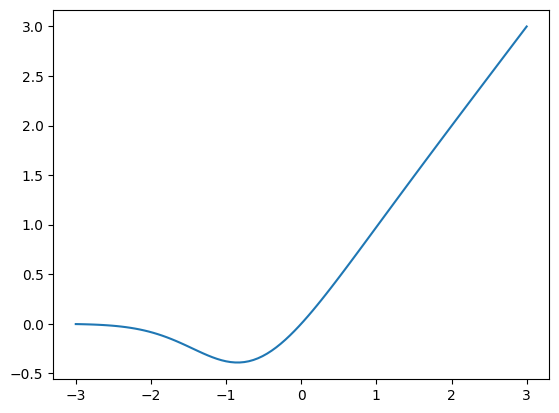

In [28]:
x = torch.linspace(-3, 3, 100)
y = gelu(x)
plt.plot(x, y)

In [29]:
GELU()(torch.tensor([-3]))

tensor([-0.0033])

In [30]:
GPT_CONFIG_124M.keys()

dict_keys(['vocab_size', 'context_length', 'emb_dim', 'n_heads', 'n_layers', 'drop_rate', 'qkv_bias'])

In [31]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layer = nn.Sequential(nn.Linear(cfg['emb_dim'], 3*cfg['emb_dim']), 
                                   GELU(),
                                   nn.Linear(3*cfg['emb_dim'], cfg['emb_dim']))
    
    def forward(self, x):
        return self.layer(x)


In [32]:
FeedForward(GPT_CONFIG_124M)(torch.rand(size=(2, 5, GPT_CONFIG_124M['emb_dim'])))

tensor([[[-0.0744, -0.0412,  0.0246,  ...,  0.0094, -0.3949, -0.0455],
         [-0.1763,  0.0134,  0.0516,  ...,  0.0109, -0.3145, -0.0871],
         [-0.2432,  0.0473,  0.0099,  ...,  0.1082, -0.3305, -0.2062],
         [-0.0491,  0.0074,  0.2479,  ...,  0.0021, -0.4358, -0.1674],
         [ 0.0037,  0.0497, -0.0375,  ..., -0.0344, -0.2831, -0.1745]],

        [[-0.0666,  0.0318,  0.0491,  ..., -0.0631, -0.5225, -0.1729],
         [-0.0637,  0.0040,  0.1824,  ..., -0.0535, -0.3629, -0.0583],
         [-0.0446,  0.0135,  0.1801,  ...,  0.0567, -0.2971, -0.2702],
         [-0.1926,  0.0112,  0.2523,  ..., -0.1479, -0.2674, -0.1477],
         [-0.2212,  0.0415,  0.0286,  ...,  0.0018, -0.3867, -0.1179]]],
       grad_fn=<ViewBackward0>)

In [33]:
class ExampleDeepNN(nn.Module):
    def __init__(self, use_shortcut, layer_sizes):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]),
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]),
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]),
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]),
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]),
                          GELU())
        ])
    
    def forward(self, x):
        for idx, layer in enumerate(self.layers):
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

x = torch.rand(size=(1, 5, 5))
ExampleDeepNN(False, [5, 5, 4, 4, 5, 5])(x)

tensor([[[-0.2953,  0.2050,  0.4440,  0.1079,  0.0751],
         [-0.2955,  0.2050,  0.4400,  0.1043,  0.0805],
         [-0.2936,  0.2016,  0.4437,  0.1182,  0.0599],
         [-0.2950,  0.2048,  0.4491,  0.1129,  0.0674],
         [-0.2960,  0.2074,  0.4522,  0.1082,  0.0755]]],
       grad_fn=<MulBackward0>)

In [34]:
torch.manual_seed(42)

x = torch.tensor([1., 0., -1.])
layers = [3, 3, 3, 3, 3, 1]
model_WithoutShortcuts = ExampleDeepNN(False, layers)

def printGradients(model: nn.Module, x):
    output = model(x)
    target = torch.tensor([0.])

    loss = nn.MSELoss()
    loss = loss(output, target)
    
    loss.backward()

    for name, params in model.named_parameters():
        if 'weight' in name:
            print(f'{name} has gradient mean of {params.grad.abs().mean().item()}')

printGradients(model_WithoutShortcuts, x)

layers.0.0.weight has gradient mean of 0.0021721646189689636
layers.1.0.weight has gradient mean of 0.003068230114877224
layers.2.0.weight has gradient mean of 0.005332197528332472
layers.3.0.weight has gradient mean of 0.025051727890968323
layers.4.0.weight has gradient mean of 0.04988626763224602


In [35]:
torch.manual_seed(42)

model_WithShortcut = ExampleDeepNN(True, layers)
printGradients(model_WithShortcut, x)

layers.0.0.weight has gradient mean of 0.044345635920763016
layers.1.0.weight has gradient mean of 0.08668603003025055
layers.2.0.weight has gradient mean of 0.08585485816001892
layers.3.0.weight has gradient mean of 0.06888672709465027
layers.4.0.weight has gradient mean of 0.1772908717393875
